In [12]:
import numpy as np
import matplotlib.pyplot as plt

from scipy.optimize import curve_fit

from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import train_test_split

from qiskit import pulse  # This is where we access all of our Pulse features!
from qiskit.circuit import Parameter  # This is Parameter Class for variable parameters.
from qiskit.circuit import QuantumCircuit, Gate
from qiskit import schedule

from qiskit.tools.monitor import job_monitor
from numpy import savetxt

import pandas as pd

pi = np.pi
qubit = 0

In [13]:
from qiskit import IBMQ

IBMQ.load_account()
provider = IBMQ.get_provider(hub='ibm-q', group='open', project='main')
backend = provider.get_backend('ibm_oslo')

ibmqfactory.load_account:WARNING:2022-08-30 23:34:16,720: Credentials are already in use. The existing account in the session will be replaced.


In [14]:
scale_factor = 1e-7


def get_job_data(job, average):
    """Retrieve data from a job that has already run.
    Args:
        job (Job): The job whose data you want.
        average (bool): If True, gets the data assuming data is an average.
                        If False, gets the data assuming it is for single shots.
    Return:
        list: List containing job result data.
    """
    job_results = job.result()  # timeout parameter set to 120 s
    result_data = []
    for i in range(len(job_results.results)):
        if average:  # get avg data
            result_data.append(np.real(job_results.get_memory(i)[qubit] * scale_factor))
        else:  # get single data
            result_data.append(job_results.get_memory(i)[:, qubit] * scale_factor)
    return result_data


def get_closest_multiple_of_16(num):
    """Compute the nearest multiple of 16. Needed because pulse enabled devices require
    durations which are multiples of 16 samples.
    """
    return int(num + 8) - (int(num + 8) % 16)



In [15]:
f01 = 4925170000.0
f12 = 4581552617.648945

d12_duration = 544
d12_amplitude = 0.10879003883868105
d12_sigma = 40

d01_duration = 544
d01_sigma = 67
d01_amplitude = 0.07999888439750123

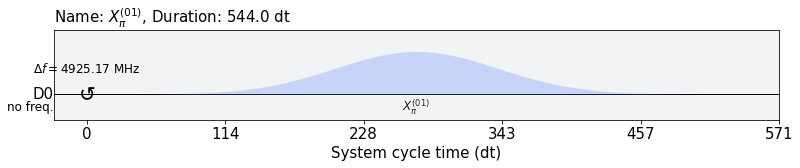

In [16]:
with pulse.build(backend=backend, default_alignment='sequential', name=r'$X_{\pi}^{(01)}$') as inst_xpi01:
    drive_chan = pulse.drive_channel(qubit)
    pulse.set_frequency(f01, drive_chan)
    pulse.play(pulse.Gaussian(duration=d01_duration,
                              amp=d01_amplitude,
                              sigma=d01_sigma,
                              name=r'$X_{\pi}^{(01)}$'), drive_chan)

xpi01 = Gate('xp01', 1, [])
inst_xpi01.draw()

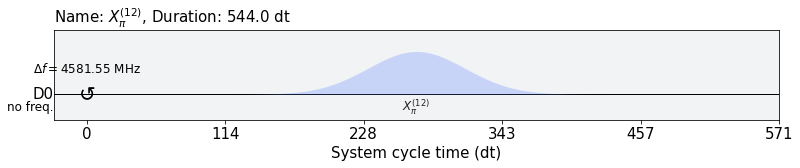

In [17]:
with pulse.build(backend=backend, default_alignment='sequential', name=r'$X_{\pi}^{(12)}$') as inst_xpi12:
    drive_chan = pulse.drive_channel(qubit)
    pulse.set_frequency(f12, drive_chan)
    pulse.play(pulse.Gaussian(duration=d12_duration,
                              amp=d12_amplitude,
                              sigma=d12_sigma,
                              name=r'$X_{\pi}^{(12)}$'), drive_chan)

xpi12 = Gate('xp12', 1, [])
inst_xpi12.draw()

In [18]:
# 0 state
ground_circs = QuantumCircuit(1, 1)
ground_circs.measure(0, 0)

# 1 state
one_circs = QuantumCircuit(1, 1)
one_circs.append(xpi01, [0])
one_circs.measure(0, 0)
one_circs.add_calibration(xpi01, (0,), inst_xpi01, [])

# 2 state
two_circs = QuantumCircuit(1, 1)
two_circs.append(xpi01, [0])
two_circs.append(xpi12, [0])
two_circs.measure(0, 0)
two_circs.add_calibration(xpi12, (0,), inst_xpi12, [])
two_circs.add_calibration(xpi01, (0,), inst_xpi01, [])


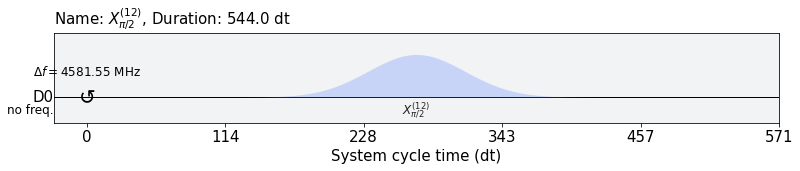

In [19]:
with pulse.build(backend=backend, default_alignment='sequential', name=r'$X_{\pi/2}^{(12)}$') as inst_X12_halfpi:
    drive_chan = pulse.drive_channel(qubit)
    pulse.set_frequency(f12, drive_chan)
    pulse.play(pulse.Gaussian(duration=d12_duration,
                              amp=d12_amplitude / 2,
                              sigma=d12_sigma,
                              name=r'$X_{\pi/2}^{(12)}$'), drive_chan)
inst_X12_halfpi.draw()

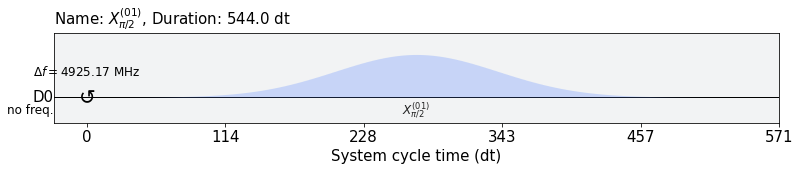

In [20]:
with pulse.build(backend=backend, default_alignment='sequential', name=r'$X_{\pi/2}^{(01)}$') as inst_X01_halfpi:
    drive_chan = pulse.drive_channel(qubit)
    pulse.set_frequency(f01, drive_chan)
    pulse.play(pulse.Gaussian(duration=d01_duration,
                              amp=d01_amplitude / 2,
                              sigma=d01_sigma,
                              name=r'$X_{\pi/2}^{(01)}$'), drive_chan)
inst_X01_halfpi.draw()

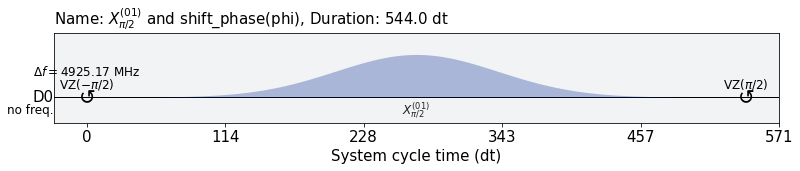

In [21]:
with pulse.build(backend=backend, default_alignment='sequential',
                 name=r'$X_{\pi/2}^{(01)}$ and shift_phase(phi)') as inst_Y01_halfpi:
    drive_duration = d01_duration
    drive_sigma = d01_sigma
    drive_chan = pulse.drive_channel(qubit)
    pulse.set_frequency(f01, drive_chan)
    with pulse.phase_offset(np.pi / 2, drive_chan):
        pulse.play(pulse.Gaussian(duration=drive_duration,
                                  amp=d01_amplitude / 2,
                                  sigma=drive_sigma,
                                  name=r'$X_{\pi/2}^{(01)}$'), drive_chan)

inst_Y01_halfpi.draw()

In [22]:
with pulse.build(backend=backend, default_alignment='sequential',
                 name=r'$Y_{-\pi/2}^{(01)}$') as inst_Y01_minus_halfpi:
    drive_duration = d01_duration
    drive_sigma = d01_sigma
    drive_chan = pulse.drive_channel(qubit)
    pulse.set_frequency(f01, drive_chan)
    with pulse.phase_offset(- np.pi / 2, drive_chan):
        pulse.play(pulse.Gaussian(duration=drive_duration,
                                  amp=d01_amplitude / 2,
                                  sigma=drive_sigma,
                                  name=r'$X_{\pi/2}^{(01)}$'), drive_chan)


In [23]:
num_exp = 96  # number of exp per run
num_series = 6  # number of series per run
num_sample = 16  # number of sample per series
exp_pos = 0
sweep_range = pi / 20  # find phi on (-sweep_range, sweep_range)
circs = [ground_circs, one_circs, two_circs]
for i in range(num_series):
    n = i + exp_pos * num_series
    for j in range(num_sample):
        exp_circs = QuantumCircuit(1, 1)
        Y01_halfpi = Gate('$Y^{(01)}_{\pi/2}$', 1, [])
        exp_circs.add_calibration(Y01_halfpi, (0,), inst_Y01_halfpi, [])

        Y01_minus_halfpi = Gate('$Y^{(01)}_{-\pi/2}$', 1, [])
        exp_circs.add_calibration(Y01_minus_halfpi, (0,), inst_Y01_minus_halfpi, [])

        X12_halfpi = Gate('$X^{(12)}_{\pi/2}$', 1, [])
        exp_circs.add_calibration(X12_halfpi, (0,), inst_X12_halfpi, [])

        exp_circs.append(Y01_halfpi, [0])
        for k in range(8 * (n + 1)):
            exp_circs.append(X12_halfpi, [0])
        exp_circs.append(Y01_minus_halfpi, [0])
        exp_circs.measure(0, 0)
        circs.append(exp_circs)

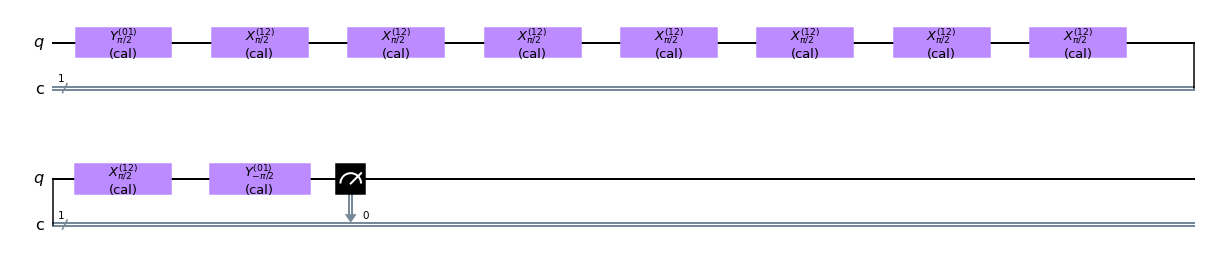

In [24]:
circs[3].draw(output='mpl')

In [25]:
np.shape(circs)

/usr/lib/python3/dist-packages/numpy/core/fromnumeric.py:1970: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  result = asarray(a).shape


(99,)

In [26]:
# Assemble the schedules into a program
job = backend.run(circs,
                  meas_level=1,
                  meas_return='single',
                  shots=20000)
job_monitor(job)

Job Status: job is queued (263)   

KeyboardInterrupt: 